# Simulated data with PANDORA (FINESST AY2023)

##### Creating spectra
- create a spectra conforming to S' = S + c1(t) x S1 + c2(t) x S2

##### Simulate PANDORA Spectra
- Use PANDORA Sim

##### Do Principal Component Analysis on data
- Extract c1, c2, plot

### PANDORA BINNING AND ADDING NOISE TO SPECTRA.

        wave  transit_depth       err  fractional_error
0   0.900000       1.000000  0.037566          0.037566
1   0.911725       0.897451  0.040765          0.045423
2   0.923775       0.915489  0.040737          0.044498
3   0.936159       0.960405  0.037304          0.038842
4   0.948889       0.948195  0.036973          0.038993
5   0.961975       0.959903  0.035955          0.037457
6   0.975428       0.977066  0.033877          0.034672
7   0.989256       0.999066  0.032295          0.032326
8   1.003471       0.955274  0.033101          0.034651
9   1.018080       0.940810  0.032948          0.035021
10  1.033092       0.862695  0.035996          0.041725
11  1.048514       0.973086  0.030685          0.031534
12  1.064352       0.909805  0.032682          0.035922
13  1.080610       0.976051  0.029738          0.030468
14  1.097291       0.941285  0.030247          0.032133
15  1.114397       0.908161  0.030842          0.033961
16  1.131927       0.939451  0.029414          0

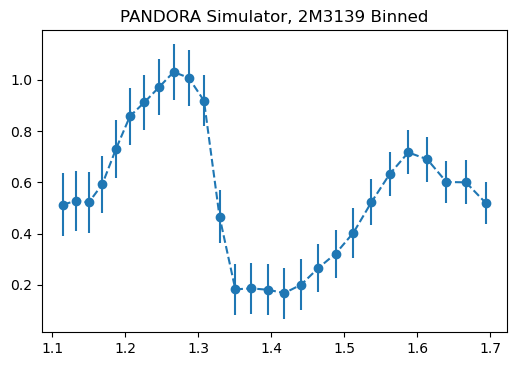

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
np.random.seed(120)

%matplotlib inline

## Use 2M3139 sample spectra from Apai 2013
header = ['x', 'y']
unbinfilename = '/Users/nguyendat/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/sm3139_spectra_reduced.csv'
spectra_unbinned = pd.read_csv(unbinfilename, names=header)

## Plot sample simulated spectra of GJ 3470b
pandoraspecfilename = '/Users/nguyendat/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/pandora-simSpec-gj3470b.csv'
gj3470b = pd.read_csv(pandoraspecfilename, names=['wave', 'transit_depth', 'err'], skiprows=1)
gj3470b.err = gj3470b.err/gj3470b.transit_depth
gj3470b.transit_depth = gj3470b.transit_depth/np.max(gj3470b.transit_depth)
gj3470b['fractional_error'] = gj3470b.err/gj3470b.transit_depth
plt.close(), plt.figure(), plt.title('PANDORA Simulator GJ3470b')
plt.errorbar(gj3470b.wave, gj3470b.transit_depth, yerr=gj3470b['err'], marker='o', ls='--')
print(gj3470b)

## Interpolate 2M3139 spectra to PANDORA resolution, add noise
interp2M3139 = interp1d(spectra_unbinned.x, spectra_unbinned.y, kind='cubic')
interpError = interp1d(gj3470b.wave, gj3470b.err, kind='cubic')
xbin = gj3470b.query('wave > 1.1').wave
ybin = interp2M3139(xbin)
spectra = pd.DataFrame()
spectra['x'], spectra['y'], spectra['err'] = xbin, ybin + 0.05*np.random.rand(), interpError(xbin)*4
plt.close(), plt.figure(dpi=100), plt.title('PANDORA Simulator, 2M3139 Binned')
plt.errorbar(spectra.x, spectra.y, yerr=spectra['err'], marker='o', ls='--')
print(spectra)

### Creating spectra

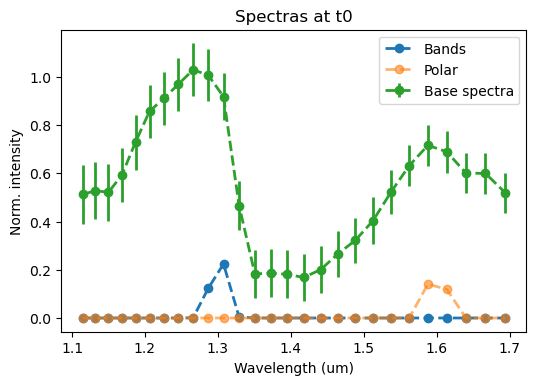

Photometry 1.1-1.7um : Base: 0.323, Base+polar: 0.330, Base+bands: 0.330


In [ ]:
# filename = '/Users/nguyendat/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/sm3139_spectra_reduced.csv'

# reduce = False
# if reduce:
#     spectra_raw = pd.read_csv(filename, names=header)
#     x0, y0 = spectra_raw.x.copy(), spectra_raw.y.copy()
#     ## Take every 2nd point of spectra array
#     spectra = pd.DataFrame(columns=header) 
#     skip = 3
#     spectra.x = x0[np.arange(0, len(x0), skip)]
#     spectra.y = y0[np.arange(0, len(y0), skip)]
#     print('original length: %i, new length: %i'%(len(x0), len(spectra.x)))
# else:
    # spectra = pd.read_csv(filename, names=header)
    
plt.close(), plt.figure(figsize=(6,4),dpi=100),
plt.xlabel('Wavelength (um)'), plt.ylabel('Norm. intensity'), plt.title('Spectras at t0')

## Treat bands and polar spectra as slopes
def polar_spectra_slope(lamda): return -1.7*lamda + 2.5
def bands_spectra_slope(lamda): return -1.4*lamda + 2.5

def polar_spectra_gaussian(lamda):
    mean = 1.6
    std = 1e-2
    return 0.3*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2))

def bands_spectra_gaussian(lamda):
    mean = 1.3
    std = 1e-2
    return 0.3*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2))

def polar_spectra_absorbslope(lamda):
    mean = 1.4
    std = 1e-2
    return -1.7 * ((0.2*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2)))+1)*lamda + 2.5

def bands_spectra_absorbslope(lamda):
    mean = 1.4
    std = 1e-2
    return -1.4 * ((0.3*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2)))+1)*lamda + 2.5

# type = 'slope'
type = 'gaussian'
# type = 'abs'

if type == 'slope':
    bandspec = bands_spectra_slope(spectra.x)
    polarspec = polar_spectra_slope(spectra.x)
elif type == 'gaussian':
    bandspec = bands_spectra_gaussian(spectra.x)
    polarspec = polar_spectra_gaussian(spectra.x) 
elif type == 'abs':
    bandspec = bands_spectra_absorbslope(spectra.x)
    polarspec = polar_spectra_absorbslope(spectra.x) 

bands = spectra.y + bandspec
# plt.plot(spectra.x, bands, label='Base + Bands spectra', c='xkcd:green',ls='--', marker='o', ms=6, lw=2)
plt.plot(spectra.x, bandspec, label='Bands', ls='--', marker='o', ms=6, lw=2)

polar = spectra.y + polarspec
# plt.plot(spectra.x, polar, label='Base + Polar spectra', c='xkcd:red',ls='--', marker='o', ms=6, lw=2)
plt.plot(spectra.x, polarspec, label='Polar', ls='--', marker='o', ms=6, lw=2, alpha=0.6)

basespec = spectra.y
plt.errorbar(spectra.x, spectra.y, yerr=spectra.err, label='Base spectra',ls='--', marker='o', ms=6, lw=2) 
plt.legend(loc='upper right'), plt.show()

basephot = np.trapz(x=spectra.x, y=spectra.y)
polarphot = np.trapz(x=spectra.x, y=polar)
bandsphot = np.trapz(x=spectra.x, y=bands)

print('Photometry 1.1-1.7um : Base: %.3f, Base+polar: %.3f, Base+bands: %.3f'%(basephot, polarphot, bandsphot))

### Generate variable spectras modulation with an arbitrary time array

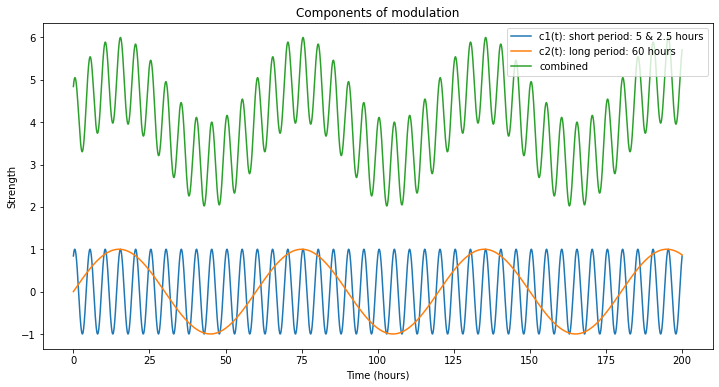

(<matplotlib.legend.Legend at 0x7fd019b61fa0>, None)

In [9]:
## Generate variable spectras modulation with an arbitrary t
## c1: short period variation of 2.5 and 5 hours 

# def c1(t, a=0.5, p1=5, p2=2.5): 
#     return a*np.sin(2*np.pi/(p1)*t -0.3) + 2*a*np.sin(2*np.pi/(p2)*t + 1) # periods (hours)

def c1(t, a=1, period=5): return a*np.sin(2*np.pi/(period)*t+1) # periods (hours)
def c2(t, a=1, period=60): return a*np.sin(2*np.pi/(period)*t) # periods (hours)

t = np.linspace(0, 200, 5000)

plt.close(), plt.figure(figsize=(12,6)), 
plt.title('Components of modulation'),
plt.plot(t, c1(t), label='c1(t): short period: 5 & 2.5 hours'),  
plt.plot(t, c2(t), label='c2(t): long period: 60 hours'),
plt.plot(t, c1(t) + c2(t)+4, label='combined'),
plt.xlabel('Time (hours)'), plt.ylabel('Strength'),
plt.legend(), plt.show()

#### Now actually generate PANDORA-timesteps array based on observation visit schedule

**** Generating PANDORA timepoint with 
3 visits, 
50 hours between visits, 
16 orbit_per_visit,
95.0 min per orbit, 
50.0 min of target visibility, 
2.0 min cadence
**** Assume visit spacing is 50 hours
**** Generating n=1200 time points for baseline of 176 hours
**** Length: 322 time points


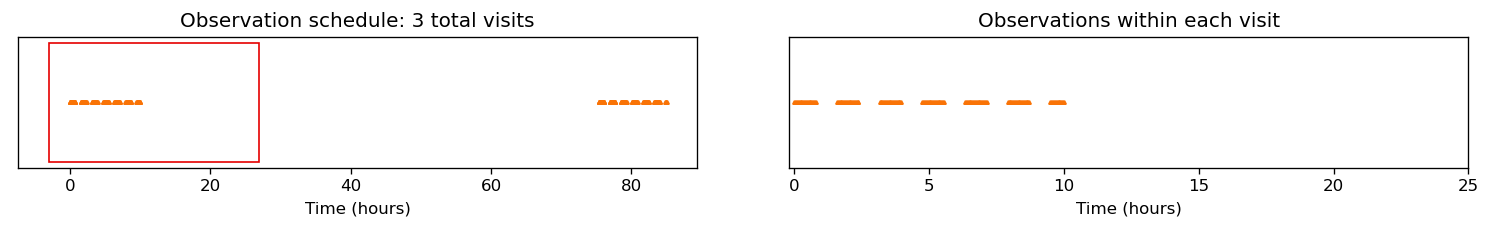

In [59]:
## Generate PANDORA-timesteps
## Assume cadence = intergration = 120 seconds 
## visits =  3 visits, each visit 16 orbits; 
## each orbit is 95 minutes 
## with 45 minutes without target visibility
def pandora_window(visit=3, orbit_per_visit=16, cadence=2, time_per_orbit=95, visibility_time=50, 
                   visit_spacing = 50, output='hour'):
    # cadence and visibility_time: unit is minutes
    # assume visit spacing in hours
    
    print('**** Generating PANDORA timepoint with \n%i visits, \n%i hours between visits, \n%i orbit_per_visit,\
\n%.1f min per orbit, \n%.1f min of target visibility, \n%.1f min cadence'%(
    visit, visit_spacing, orbit_per_visit, time_per_orbit, visibility_time, cadence))
    print('**** Assume visit spacing is %i hours'%(visit_spacing))
    
    invisibility_time = time_per_orbit-visibility_time
    
    if output == 'hour':
        # convert t to hours
        time_per_orbit/=60
        visibility_time/=60
        cadence/=60
        invisibility_time/=60

    n_per_orbit = int(visibility_time/cadence)
    n = int(n_per_orbit * orbit_per_visit * visit)
    baseline = time_per_orbit * orbit_per_visit * visit + (visit-1) * visit_spacing
    print('**** Generating n=%i time points for baseline of %i hours'%(n, baseline))
    
    time_step = []
    for i in range(n):
        value = 0
        if i == 0:
            time_step.append((i, value))
        else:
            if i%400 == 0: value += visit_spacing
            if i%n_per_orbit == 0: value+=invisibility_time
            value += (time_step[-1][1] + cadence)
            
            # if not( 10<value<=25 or 85<value<=100 or 160<value<=175 ):
            if True:
                time_step.append((i, value))
            
    return time_step, n

tsim, n = pandora_window(visit=3, orbit_per_visit=16, cadence=2, time_per_orbit=95, visibility_time=50, 
                   visit_spacing = 50, output='hour')
tsim = np.array(tsim)[:,1]

empty = []
for y in tsim:
    # if 0<=y<=10 or 75<=y<=85 or 150<=y<=160:
    if 0<=y<=10 or 75<=y<=85:
        empty.append(y)
tsim = []
tsim = np.array(empty)

from matplotlib.patches import Rectangle
plt.close()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,2), dpi=120)
ax1.set_title('Observation schedule: 3 total visits')
ax1.set_xlabel('Time (hours)')
# create rectangle
rect = Rectangle((-3, -0.5), 30, 1, linewidth=1, edgecolor='xkcd:red', facecolor='none')
# Add the patch to the current axes
ax1.add_patch(rect)

ax1.plot(tsim, np.zeros(len(tsim)), c='xkcd:orange', ls='', marker='^', ms=2)
ax2.set_xlim((-0.2, 176))

ax2.plot(tsim, np.zeros(len(tsim)), c='xkcd:orange', ls='', marker='^', ms=2)

ax2.set_title('Observations within each visit')
ax2.set_xlim((-0.2, 25))
ax2.set_xlabel('Time (hours)'), plt.tight_layout()

ax1.set_yticks([]), ax2.set_yticks([])
print('**** Length: %i time points'%(len(tsim)))

#### Let's generate Pandora-observation-like time-step array

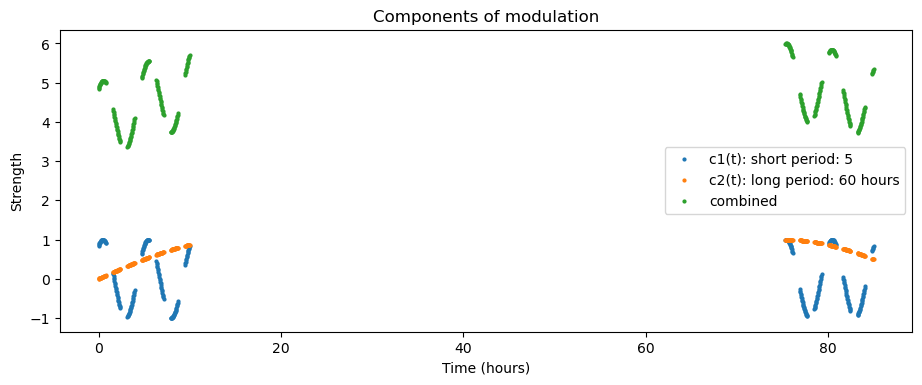

(<matplotlib.legend.Legend at 0x7fd01afd8d60>, None)

In [60]:
## Generate variable spectras modulation with simulate PANDORA timestep
## c1: short period variation of 2.5 and 5 hours 

# def c1(t, a=0.5, p1=5, p2=2.5): 
#     return a*np.sin(2*np.pi/(p1)*t -0.3) + 2*a*np.sin(2*np.pi/(p2)*t + 1) # periods (hours)

def c1(t, a=1, period=5): return a*np.sin(2*np.pi/(period)*t+1) # periods (hours)
def c2(t, a=1, period=60): return a*np.sin(2*np.pi/(period)*t) # periods (hours)

t = tsim.copy()

plt.close(), plt.figure(figsize=(11,4), dpi=100), 
plt.title('Components of modulation'),
plt.plot(t, c1(t), label='c1(t): short period: 5', ls='', marker='o', ms=2),  
plt.plot(t, c2(t), label='c2(t): long period: 60 hours', ls='', marker='o', ms=2),
plt.plot(t, c1(t) + c2(t)+4, label='combined', ls='', marker='o', ms=2),
plt.xlabel('Time (hours)'), plt.ylabel('Strength'),
plt.legend(), plt.show()

### GENERATE PANDORA SPECTRAL CUBE

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.114397,1.131927,1.149878,1.168246,1.187022,1.206199,1.225765,1.245705,1.266005,1.286646,...,1.464364,1.488240,1.512504,1.537165,1.562227,1.587698,1.613584,1.639893,1.666630,1.693803
1,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030616,1.111179,...,0.265825,0.322327,0.403583,0.522541,0.632232,0.716433,0.689839,0.601200,0.599865,0.519689
2,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030636,1.113871,...,0.265825,0.322327,0.403583,0.522541,0.632233,0.716924,0.690255,0.601200,0.599865,0.519689
3,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030655,1.116377,...,0.265825,0.322327,0.403583,0.522541,0.632234,0.717415,0.690671,0.601201,0.599865,0.519689
4,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030672,1.118692,...,0.265825,0.322327,0.403583,0.522541,0.632235,0.717907,0.691087,0.601201,0.599865,0.519689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030521,1.098648,...,0.265825,0.322327,0.403583,0.522541,0.632355,0.788510,0.750893,0.601254,0.599865,0.519689
319,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030547,1.102034,...,0.265825,0.322327,0.403583,0.522541,0.632354,0.788088,0.750535,0.601253,0.599865,0.519689
320,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030571,1.105256,...,0.265825,0.322327,0.403583,0.522541,0.632353,0.787664,0.750177,0.601253,0.599865,0.519689
321,0.512942,0.527826,0.521862,0.592134,0.729826,0.857525,0.911200,0.969840,1.030594,1.108306,...,0.265825,0.322327,0.403583,0.522541,0.632352,0.787240,0.749817,0.601253,0.599865,0.519689


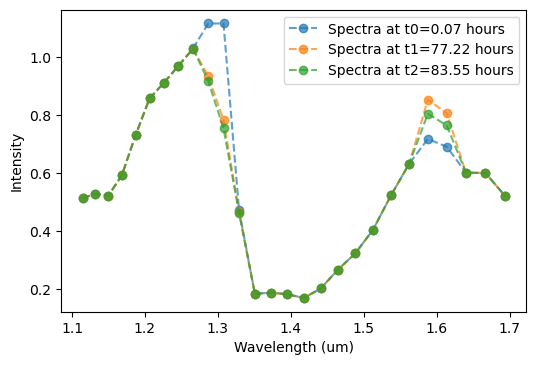

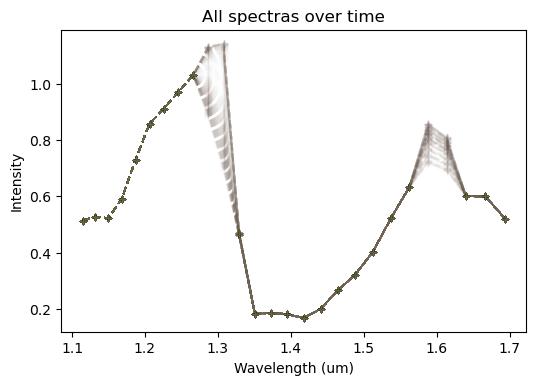

In [61]:
## Generate a modulated spectra
lam = np.array(spectra.x)
dataTable = [lam]
spectraCube2 = []
spectraCube, spectraCubeNoTime = [], []
for timestep in t: 
    # print(timestep)
    modulatedSpectra = np.array(basespec + c1(timestep)*bandspec + c2(timestep)*polarspec)
    time = timestep * np.ones(len(lam))
    spectraCube.append((timestep, (lam, modulatedSpectra)))
    # print(table0)
    table0 = (time, lam, modulatedSpectra)
    for i,lamda in enumerate(lam):
        spectraCube2.append((time[i], lamda, modulatedSpectra[i]))
    spectraCubeNoTime.append((lam, modulatedSpectra))
    dataTable.append(modulatedSpectra)
dataTable = np.transpose(dataTable)
    
# Convert to np.array
spectraCubeNoTime = np.array(spectraCubeNoTime)
    
spec002 = spectraCube[2]
spec200 = spectraCube[200]
spec400 = spectraCube[300]

plt.close(), 
plt.figure(dpi=100)
plt.plot(spec002[1][0], spec002[1][1], label='Spectra at t0=%.2f hours'%(spec002[0]), ls='--', marker='o', ms=6, alpha=0.7)
plt.plot(spec200[1][0], spec200[1][1], label='Spectra at t1=%.2f hours'%(spec200[0]), ls='--', marker='o', ms=6, alpha=0.7)
plt.plot(spec400[1][0], spec400[1][1], label='Spectra at t2=%.2f hours'%(spec400[0]), ls='--', marker='o', ms=6, alpha=0.7)
plt.legend(), plt.xlabel('Wavelength (um)'), plt.ylabel('Intensity') 

plt.figure(dpi=100), plt.title('All spectras over time')
for i in range(len(tsim)):
    specnum = spectraCube[i]
    plt.plot(specnum[1][0], specnum[1][1], ls='--', marker='+', ms=6, alpha=0.01)
plt.xlabel('Wavelength (um)'), plt.ylabel('Intensity')

# df = pd.DataFrame(spectraCube2)
# df = pd.DataFrame(dataTable)
df = pd.DataFrame(np.transpose(dataTable))
# df = df.rename(columns={'0':'lamda'})
# print(df.shape)
# df.iloc[:,0]
# df = df.iloc[:,1:3]
df

### PLOT THE PANDORA 3D SPECTRAL CUBE

[(1.1, 1.7),
 (1.0, 20.0),
 (0.0, 1.0),
 Text(0.5, 0, 'Wavelength $(\\mu m)$'),
 Text(0.5, 0, 'Time step'),
 Text(0.5, 0, 'Flux')]

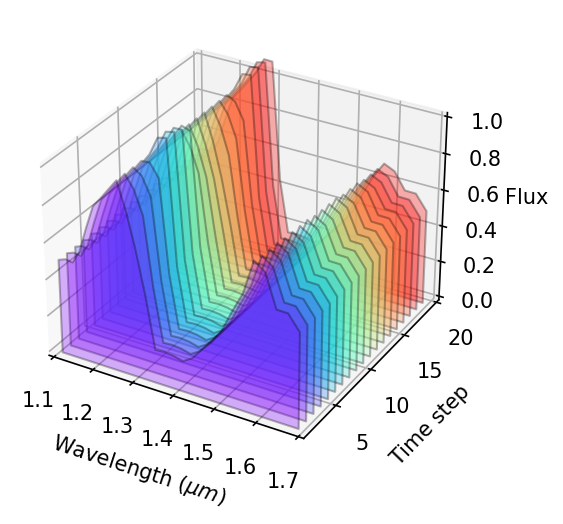

In [62]:
## PLOT 3D SPECTRAL CUBE

from matplotlib.collections import PolyCollection
from matplotlib import cm
viridis = cm.get_cmap('rainbow_r', 12)

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]


ax = plt.figure(dpi=150).add_subplot(projection='3d')
n= 20
skip=6
lambdas = range(1, n)

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(spectraCube[i+skip*(i-1)][1][0], spectraCube[i+skip*(i-1)][1][1]) for i in lambdas]
facecolors = viridis(np.linspace(0, 1, len(verts)))

poly = PolyCollection(verts, facecolors=facecolors, edgecolors=("black"), alpha=.3)
ax.add_collection3d(poly, zs=np.flip(lambdas), zdir='y')

ax.set(xlim=(1.1, 1.7), ylim=(1, n), zlim=(0, 1.0),
       xlabel=r'Wavelength $(\mu m)$', ylabel='Time step', zlabel='Flux')

# plt.show()

(323, 27)
(323, 2)


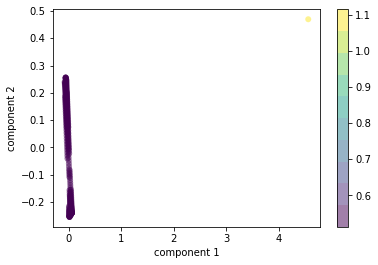

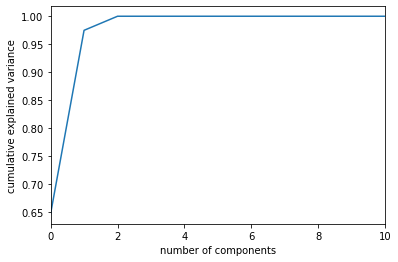

In [63]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(df)
print(df.shape)
print(projected.shape)

plt.close(), plt.figure()
plt.scatter(projected[:, 0], projected[:, 1], c=df.iloc[:,0], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

pca = PCA().fit(df)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xlim((0,10))
plt.ylabel('cumulative explained variance');


## Implement a PCA analysis

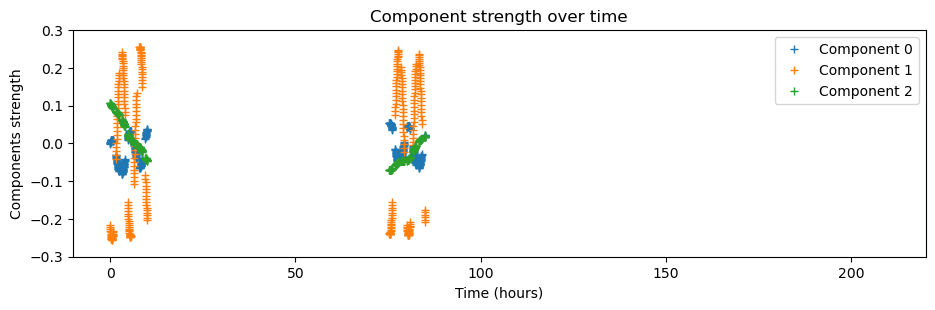

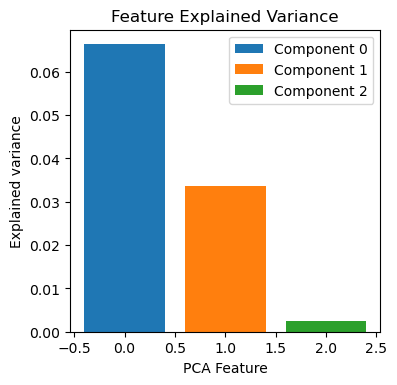

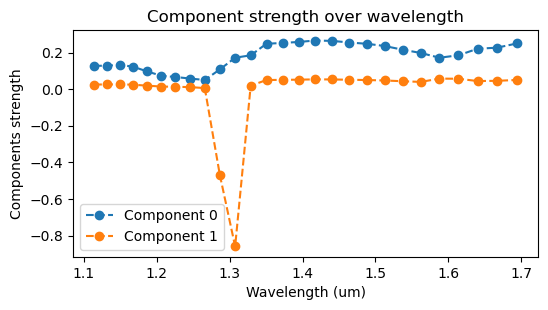

In [64]:
%matplotlib inline
## flatten the data
# X = np.transpose(dataTable) # already a 2D data format as required
# X = dataTable # already a 2D data format as required

### implement a PCA with n_components
# if n_component > 1: choose n first-most-important component
# if n_component < 1: choose percertage value of component sum that preserves n% data variability
pca = PCA(n_components=0.9999)
# pca = PCA(n_components=3)
pca.fit(df)
X_pca = pca.transform(df)
# pca.components_

# print("Relative variance in principal components:", pca.explained_variance_ratio_)

# plt.close(), plt.figure(figsize=(10,5))
# plt.plot(X_pca, ls='', marker='+', ms=6, lw=1), plt.xlabel('Observations'), plt.ylabel('Transformed data')
# if type == 'gaussian': plt.ylim((-1,1))
# # plt.yscale('log')

plt.figure(figsize=(11,3),dpi=100), plt.title('Component strength over time')
for i, comp in enumerate(np.transpose(X_pca)):
    # print(comp)
    plt.plot(t, comp[1:], ls='', marker='+', ms=6, lw=1, label='Component %i'%i), 
    plt.xlabel('Time (hours)'), plt.ylabel('Components strength'), plt.legend(loc='upper right')
    # if type == 'gaussian': plt.ylim((-1,1))
    if type == 'gaussian': plt.ylim((-0.3,0.3))
    plt.xlim((-10,220))
# plt.yscale('log')

# Bar plot of explained_variance
plt.figure(figsize=(4,4),dpi=100)
for i, variance in enumerate(pca.explained_variance_):
    plt.bar(i,variance, label='Component %i'%i)
plt.xlabel('PCA Feature'), plt.ylabel('Explained variance'), plt.legend(loc='upper right')
plt.title('Feature Explained Variance'), plt.show()

color = []
plt.figure(figsize=(6,3),dpi=100), plt.title('Component strength over wavelength')
for i, comp in enumerate(pca.components_):
    if i==2: continue
    else:
        if type == 'gaussian':
            y = comp
        else:
            y = -comp
        g = plt.plot(lam, y, ls='--', marker='o', ms=6, lw=1.5, label='Component %i'%i)
        plt.xlabel('Wavelength (um)'), plt.ylabel('Components strength'), plt.legend()
        color.append(g[0].get_color())

[9] [22]


InvalidIndexError: (slice(None, None, None), None)

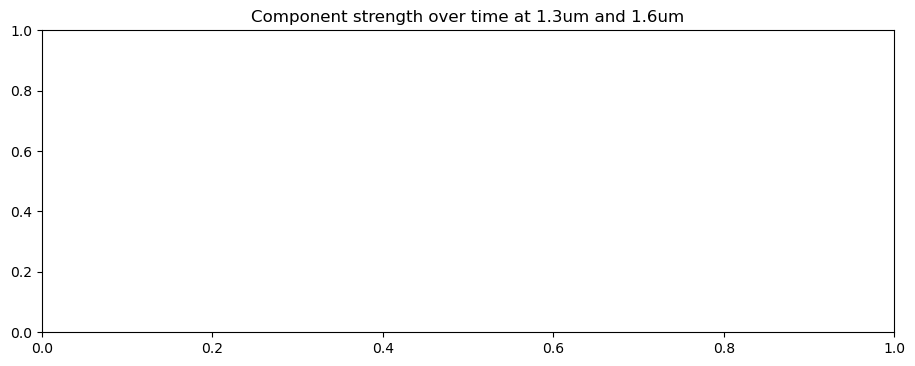

In [65]:
if type == 'gaussian':
    # a = np.where(np.logical_and(lam>1.29, lam<1.30))
    # b = np.where(np.logical_and(lam>1.595, lam<1.60))
    # c = np.where(np.logical_and(lam>1.39, lam<1.40))
    # print(a,b,c)
    
    a = np.where(np.logical_and(lam>1.28, lam<1.30))[0]
    b = np.where(np.logical_and(lam>1.58, lam<1.60))[0]
    print(a,b)

    df1 = df.iloc[:, a][1:]
    df2 = df.iloc[:, b][1:]

    plt.close(), plt.figure(figsize=(11, 4),dpi=100), plt.title('Component strength over time at 1.3um and 1.6um')
    plt.plot(t, df1, label='1.3um feature - band component', marker='+', ls='')
    plt.plot(t, df2, label='1.6um feature - polar component', marker='o', ls='')
    plt.xlabel('Time (hours)'), plt.ylabel('Component strength')
    plt.legend()
    
else:
    print('Analysis not optimal for this type of spectral features')

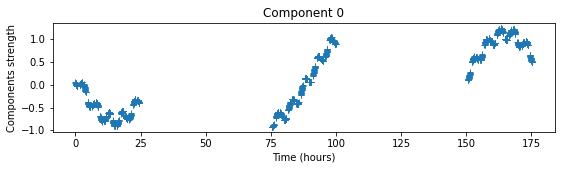

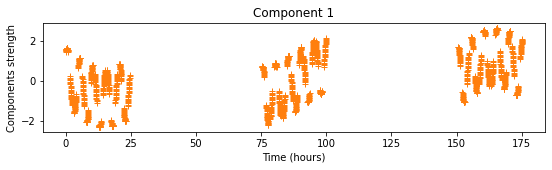

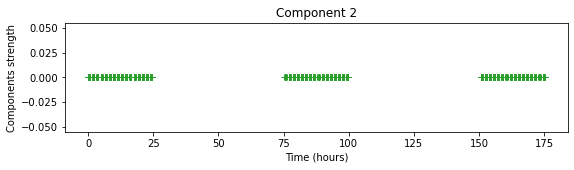

In [353]:
if type == 'abs' or type == 'slope':
    # %matplotlib widget
    %matplotlib inline
    all = np.transpose(X_pca)
    
    for i,comp in enumerate(all):
        if i==0: 
            a=2
            targ = all[a, 1:]/np.max(all[a, 1:])
        elif i==1: 
            targ = all[0, 1:]/np.max(all[0, 1:]) + all[2, 1:]/np.max(all[2, 1:])
        elif i==2: 
            a=2
            targ = all[a, 1:]/np.max(all[a, 1:])
        
        y = comp[1:]/np.max(comp[1:])
        # print(comp, targ)
        plt.figure(figsize=(9,2),dpi=100)
        plt.title('Component %i'%i)
        plt.plot(t, (y-targ), ls='', marker='+', ms=6, lw=1, c=color[i]), 
        # plt.plot(t, (comp[1:]), ls='', marker='+', ms=6, lw=1, c=color[i]), 
        plt.xlabel('Time (hours)'), plt.ylabel('Components strength')
else:
    print('Analysis not optimal for this type of spectral features')